- **purpose**: 1. Determine what percentage of the tiles in the dataset has have what percentage of ground classified points. 2. Plot "Cumulative Distribution of % Ground Points per Tile". 3. Plot "Average Area vs Ground Point % and Bin Counts". 4. Show ESRI satellite data images of tiles with the highest percentage of ground classified points

- **status**: Working. Getting ESRI satellite images (with `satellite.fetch_esri_from_XXX()`) is brittle and returns server error 500 for small tiles (minimum tile width determined by location, but >250 m is usually safe).

- **next**: None

- **conclusion**: Percent of tiles with ground point % > 5% (10%): 0.14% (0.06%) (425 counts (180 counts))

In [120]:
import os
import pandas as pd
import numpy as np
import sys
import requests

from PIL import Image
from io import BytesIO
import pathlib

# compute absolute path to the project root's src/
sys.path.insert(0, os.path.join(os.getcwd(), "src"))

# import project specific (src/project_utils/...) packages #
from project_utils import config as proj_config
from project_utils import io as proj_io
from project_utils import geo as proj_geo
from project_utils import lidar as proj_lidar
from project_utils import raster as proj_raster
from project_utils import satellite as proj_satellite
from project_utils import vis as proj_vis
from project_utils import scratch as proj_scratch

# auto-reload any module that changes on disk
%load_ext autoreload
%autoreload
# %reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
inventory_name = "cms_brazil_lidar_tile_inventory.csv"
metadata_name = "cms_brazil_lidar_tile_metadata.csv"

def get_path_to_data(filename):
    path_to_file = os.path.join(
        os.getcwd(),
        "data",
        "metadata",
        filename
    )
    return path_to_file

path_to_inv = get_path_to_data(inventory_name)
path_to_meta =  get_path_to_data(metadata_name)

In [122]:
df_inv = pd.read_csv(path_to_inv)
df_meta = pd.read_csv(path_to_meta)

print(f"Length of inventory: {len(df_inv)}")
print(f"Length of metadata: {len(df_meta)}")
print("")

print(f"Inventory columns: {df_inv.columns}")
print(f"Metadata columns: {df_meta.columns}")
print("")

print(f"Filename of row 0 entry for inventory: {df_inv.iloc[0]['filename']}")
print(f"Filename of row 0 entry for metadata: {df_meta.iloc[0]['filename']}")

Length of inventory: 3152
Length of metadata: 3145

Inventory columns: Index(['filename', 'max_lat', 'min_lat', 'max_lon', 'min_lon', 'file_type',
       'file_size_mb', 'file_format', 'version', 'created', 'utmzone', 'srs'],
      dtype='object')
Metadata columns: Index(['filename', 'max_lat', 'min_lat', 'max_lon', 'min_lon', 'file_type',
       'file_size_mb', 'file_format', 'version', 'created', 'utmzone', 'srs',
       'n_points_total', 'class_0_count', 'class_0_pct', 'class_1_count',
       'class_1_pct', 'class_2_count', 'class_2_pct', 'class_3_count',
       'class_3_pct', 'class_4_count', 'class_4_pct', 'class_5_count',
       'class_5_pct', 'class_6_count', 'class_6_pct', 'class_7_count',
       'class_7_pct', 'class_8_count', 'class_8_pct', 'class_9_count',
       'class_9_pct', 'class_10_count', 'class_10_pct', 'class_11_count',
       'class_11_pct', 'class_12_count', 'class_12_pct', 'class_13_count',
       'class_13_pct', 'class_14_count', 'class_14_pct', 'class_15_count'

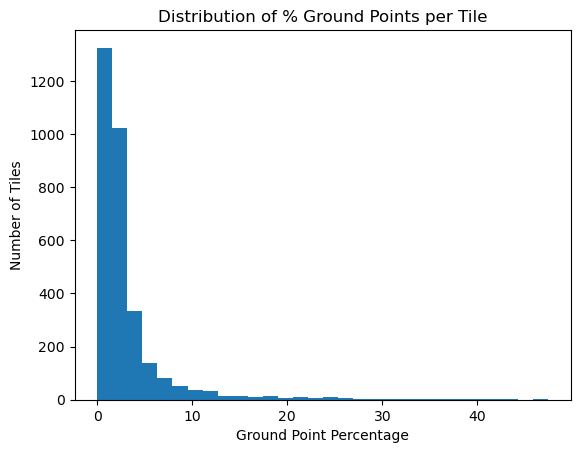

In [123]:
import matplotlib.pyplot as plt

plt.hist((df_meta['ground_pct']*100).dropna(), bins=30)
plt.xlabel('Ground Point Percentage')
plt.ylabel('Number of Tiles')
plt.title('Distribution of % Ground Points per Tile')
plt.show()

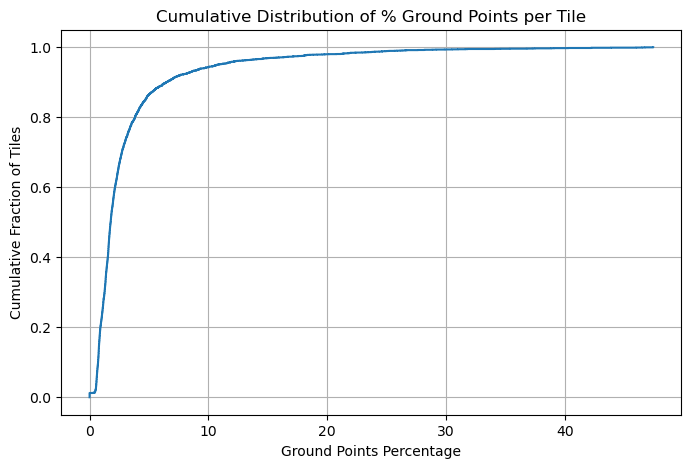

In [124]:
# Drop NaN values for safety
ground_pcts = (df_meta['ground_pct']*100).dropna()

# Sort values
sorted_pcts = np.sort(ground_pcts)

# Compute cumulative sum (in terms of counts or percentages)
cum_counts = np.arange(1, len(sorted_pcts) + 1)
cum_frac = cum_counts / len(sorted_pcts)

plt.figure(figsize=(8, 5))
plt.step(sorted_pcts, cum_frac, where='post')
plt.xlabel('Ground Points Percentage')
plt.ylabel('Cumulative Fraction of Tiles')
plt.title('Cumulative Distribution of % Ground Points per Tile')
plt.grid(True)
plt.show()

In [125]:
for thresh in [5, 10, 20, 30]:
    pct_above = np.mean(sorted_pcts > thresh)
    count_above = np.sum(sorted_pcts > thresh)
    print(f"Percent of tiles with ground point % > {thresh}%: {pct_above:.2f} % ({count_above} counts)")

Percent of tiles with ground point % > 5%: 0.14 % (425 counts)
Percent of tiles with ground point % > 10%: 0.06 % (180 counts)
Percent of tiles with ground point % > 20%: 0.02 % (63 counts)
Percent of tiles with ground point % > 30%: 0.01 % (20 counts)


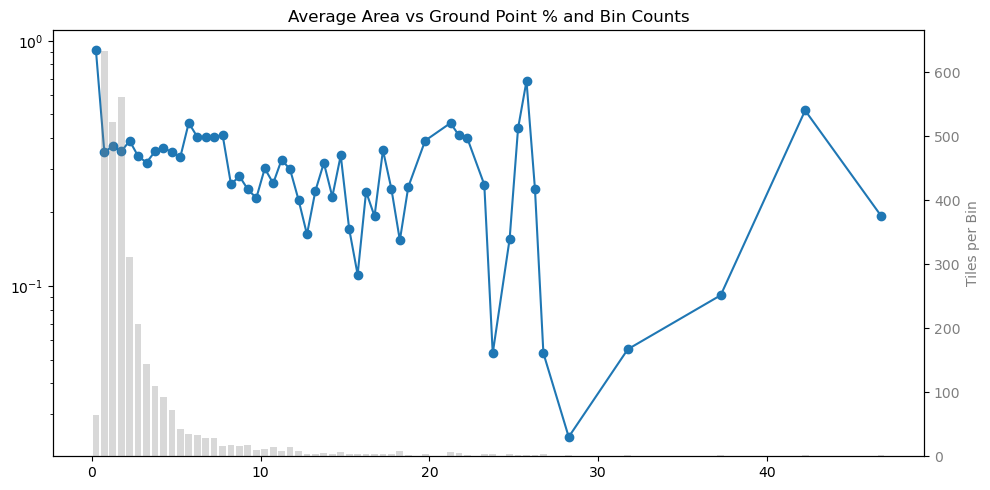

In [134]:
# Assume df_meta['ground_pct'] is 0-1 float (not percent) and df_meta['tile_area_m2'] exists
df = df_meta.copy()  # non-destructive

# Convert to percent
df["ground_pct_percent"] = df["ground_pct"] * 100

# Choose binning: 0.1% bin width (bins are 0, 0.1, 0.2, ... 100)
bin_width = 0.5
bins = np.arange(0, 100 + bin_width, bin_width)
bin_labels = bins[:-1] + bin_width / 2

# Digitize the ground_pct_percent into bins
df["ground_pct_bin"] = np.digitize(df["ground_pct_percent"], bins) - 1  # bin indices

# Compute average area per bin
mean_areas = df.groupby("ground_pct_bin")["tile_area_m2"].mean()
counts = df.groupby("ground_pct_bin")["tile_area_m2"].count()

# Remove bins with no data (NaNs)
valid = ~mean_areas.isna() & (counts > 1)  # At least 2 tiles per bin to smooth plot (optional)
mean_areas = mean_areas[valid]
bin_labels_valid = bin_labels[mean_areas.index]

fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar plot for counts (secondary axis)
color = 'tab:gray'
ax2 = ax1.twinx()
ax2.bar(bin_labels_valid, counts[mean_areas.index], 
        width=bin_width*0.8, alpha=0.3, color=color, label="N tiles (bin count)")
ax2.set_ylabel('Tiles per Bin', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.plot(bin_labels_valid[valid_bins], mean_areas[valid_bins]*1e-6, marker='o', color='tab:blue')
ax1.set_yscale('log')

# Line plot for mean area
# color = 'tab:blue'
# ax1.plot(bin_labels_valid, mean_areas*1e-6, marker='o', color=color, label="Avg area per bin")
# ax1.set_xlabel('Ground Point Percentage (%)')
# ax1.set_ylabel('Average Tile Area (km²)', color=color)
# ax1.tick_params(axis='y', labelcolor=color)

plt.title('Average Area vs Ground Point % and Bin Counts')
fig.tight_layout()
plt.show()

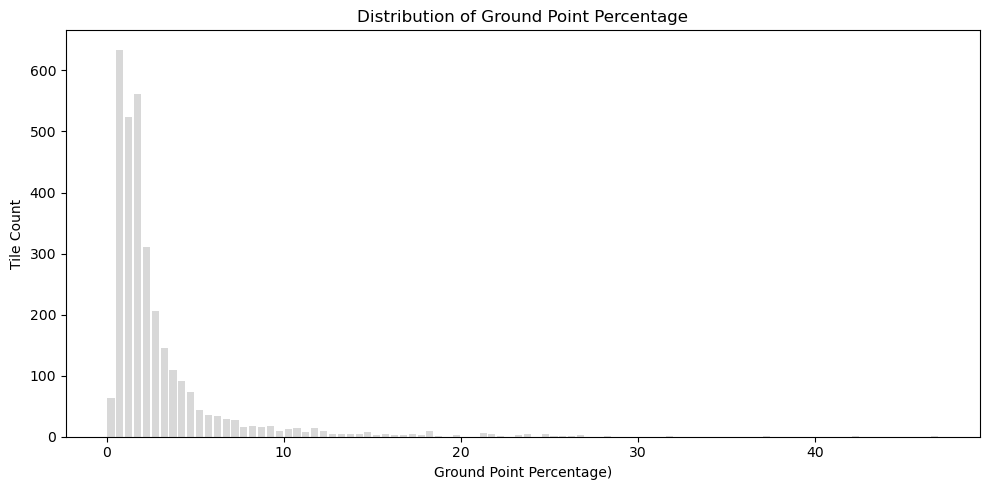

In [154]:
df = df_meta.copy()
ground_pct_percent = df["ground_pct"] * 100

# Avoid log(0): filter zeros or add a tiny epsilon
eps = 1e-3
filtered = ground_pct_percent[ground_pct_percent > eps]
# log_vals = np.log10(filtered)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar plot for counts (secondary axis)
color = 'tab:gray'
ax1.bar(bin_labels_valid, counts[mean_areas.index], 
        width=bin_width*0.8, alpha=0.3, color=color, label="N tiles (bin count)")

plt.xlabel("Ground Point Percentage)")
plt.ylabel('Tile Count')
plt.title('Distribution of Ground Point Percentage')
plt.tight_layout()
# plt.yscale("log")
plt.show()

In [158]:
df.columns

Index(['filename', 'max_lat', 'min_lat', 'max_lon', 'min_lon', 'file_type',
       'file_size_mb', 'file_format', 'version', 'created', 'utmzone', 'srs',
       'n_points_total', 'class_0_count', 'class_0_pct', 'class_1_count',
       'class_1_pct', 'class_2_count', 'class_2_pct', 'class_3_count',
       'class_3_pct', 'class_4_count', 'class_4_pct', 'class_5_count',
       'class_5_pct', 'class_6_count', 'class_6_pct', 'class_7_count',
       'class_7_pct', 'class_8_count', 'class_8_pct', 'class_9_count',
       'class_9_pct', 'class_10_count', 'class_10_pct', 'class_11_count',
       'class_11_pct', 'class_12_count', 'class_12_pct', 'class_13_count',
       'class_13_pct', 'class_14_count', 'class_14_pct', 'class_15_count',
       'class_15_pct', 'class_16_count', 'class_16_pct', 'class_17_count',
       'class_17_pct', 'class_18_count', 'class_18_pct', 'class_19_count',
       'class_19_pct', 'n_points_ground', 'ground_pct',
       'n_points_unclassified', 'n_points_veg_low', 'n_poi

In [153]:
summary = df[["ground_pct"]].agg(['mean', 'std']) * 100  # returns a DataFrame
print(summary)

      ground_pct
mean    3.204456
std     4.741438


In [157]:
df["point_density"] = df["n_points_total"] / df["tile_area_m2"]
summary = df["point_density"].agg(['mean', 'std'])
print(summary)

mean    27.904364
std     34.058105
Name: point_density, dtype: float64


In [159]:
df["class_2_density"] = df["class_2_count"] / df["tile_area_m2"]
summary = df["class_2_density"].agg(['mean', 'std'])
print(summary)

mean    0.626038
std     0.661998
Name: class_2_density, dtype: float64


In [58]:
selected = df_meta[df_meta['ground_pct'] > 0.1]

# Step 2: Print info for first 5 such tiles (modify as needed)
filename = "CAN_A01_2014_laz_5.laz"
row = df_meta[df_meta["filename"] == filename]
min_lat = row['min_lat']
max_lat = row['max_lat']
min_lon = row['min_lon']
max_lon = row['max_lon']
tile_area_km2 = row['tile_area_m2']*1e-6
ground_pct = row['ground_pct']
print(f"Filename: {filename}")
# print(f"Bounding box: min_lat={min_lat}, max_lat={max_lat}, min_lon={min_lon}, max_lon={max_lon}, ground percentage={ground_pct*100:.2f}, tile area (m**2): {tile_area_km2:.2f}")
print("-" * 40)

# (Optional) Fetch and display/save the ESRI satellite image

img = proj_satellite.fetch_esri_from_row(df_meta, filename)
img.show()  # or save with save_path="path/to/save.jpg"

Filename: CAN_A01_2014_laz_5.laz
----------------------------------------
[satellite] Downloading ESRI image for CAN_A01_2014_laz_5.laz...


In [59]:
filename

'CAN_A01_2014_laz_5.laz'

CAN_A01_2014_laz_5.laz
Dimensions (w x h): 1007 x 750
Area: 0.75 km**2


Text(0.5, 1.0, 'CAN_A01_2014_laz_5.laz')

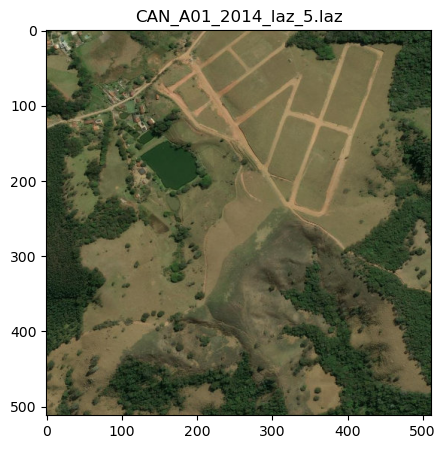

In [119]:
filename = selected.iloc[2]["filename"]
deg_dif = 0.00

coords = proj_satellite.get_coords_from_df(selected, filename)
min_lat, max_lat, min_lon, max_lon = coords
min_lat -= deg_dif
max_lat += deg_dif
min_lon -= deg_dif
max_lon += deg_dif
coords = min_lat, max_lat, min_lon, max_lon

width_m, height_m = proj_satellite.get_bbox_sides_from_coords(coords)
area = proj_satellite.get_bbox_area_from_coords(coords)

print(filename)
print(f"Dimensions (w x h): {width_m:.0f} x {height_m:.0f}")
print(f"Area: {area*1e-6:.2f} km**2")

px_width=512
px_height=512

url = "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export"
params = {
    "bbox": f"{min_lon},{min_lat},{max_lon},{max_lat}",
    "bboxSR": 4326,
    "imageSR": 4326,
    "size": f"{px_width},{px_height}",
    "format": "jpg",
    "f": "image"
}
response = requests.get(url, params=params)
response.raise_for_status()
img = Image.open(BytesIO(response.content))

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(filename)